## CORE

In [ ]:
!pip install fastcore fastai2 -q

     |████████████████████████████████| 194kB 9.7MB/s 


In [ ]:
from fastcore.foundation import *
from fastai2.vision.all import *
from fastai2.text.all import *
import pathlib

In [ ]:
@patch
def ls(x: pathlib.Path):
    return list(x.iterdir())

In [ ]:
# import os
# from pathlib import Path
from google.colab import drive

In [ ]:
def create_path(path):
    if not os.path.isdir(path):
        path.mkdir(parents=True, exist_ok=True)
    return path

In [ ]:
colab_path = Path('/content')

handles all gdrive downloads for when running on cluster

In [ ]:
create_path(colab_path/'dataset');
create_path(colab_path/'models');

!git clone --quiet 'https://github.com/tezike/download_google_drive.git'
os.chdir('download_google_drive')
!python download_gdrive.py '10rH0nAxa7mWS289xIyRP-mOOowqiIolL' '../dataset/temp.tgz'
# !python download_gdrive.py '136CD5oP9YCYeal0hwdtF5oRMAk4YWa2M' '../dataset/df_all.csv'
shutil.rmtree('../download_google_drive')
os.chdir('..')

## Colab_setup

In [ ]:
#you don't need when running from cluster

# from google.colab import drive
# drive.mount('/content/drive')
# root_dir = Path('/content/drive/My Drive')
# base_path = create_path(root_dir/'Rakuten')
# base_path

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Path('/content/drive/My Drive/Rakuten')

In [ ]:
# colab_path = Path('/content')

In [ ]:
# data_path = create_path(base_path/'dataset')

In [ ]:
# model_path = create_path(base_path/'models')

In [ ]:
# shutil.rmtree(data_path)

## download and untar data

In [ ]:
!tar -xzf 'dataset/temp.tgz'

tar (child): $/content/lm-encoder-splits.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
# (colab_path/'SIGIR-2020-EComDC-release').ls()

In [ ]:
# path = colab_path/'SIGIR-2020-EComDC-release'

In [ ]:
df_all = pd.read_csv(base_path/'dataset/df_all.csv'); df_all.sample(1)

,Title,Description,Image_id,Product_id,Prdtypecode,Prdlbl,image_path
63603,Pompe pour fontaine 280 W 1 000 L / h,<p>Avec une capacité de 1 000 litres par heure cette pompe est un choix idéal pour les étangs de taille moyenne ou grande les cascades et les plans d&#39;eau. Cette pompe de haute qualité vous permet de créer des plans d&#39;eau uniques. La pompe de bassin est équipée d&#39;un moteur économe en énergie qui a une grande capacité et une faible consommation d&#39;énergie. La hauteur maximale de pompage de cette pompe est de 60 mètres. La conception compacte et le fonctionnement silencieux en font un choix parfait pour tous vos besoins aquatiques. De plus cette pompe est également livrée avec ...,1266792345,3939953275,2585,2585,/content/SIGIR-2020-EComDC-release/image/image_training/image_1266792345_product_3939953275.jpg


## Datasets and DataLoaders

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

In [ ]:
MAX_SEQ_LEN = 128

In [ ]:
files = get_image_files(colab_path/'SIGIR-2020-EComDC-release/image/image_training', recurse=True); len(files)

84916

I'll resize the images from 500px to 224px using LANCZOZ interpolation(tested and found it works better than BILINEAR, BICUBIC and NEAREST)

Load the saved files by running cell below

In [ ]:
def pre_process_image(path, save_path = 'images_224', save_dir=colab_path, size=(224, 224)):
    image_dir = create_path(save_dir/save_path)
    im = Image.open(path).resize((size), resample=Image.LANCZOS)
    im.save(image_dir/f'{str(path.name)}', quality=95)
    return Path(image_dir/f'{str(path.name)}', quality=95)

In [ ]:
# cleanup
# shutil.rmtree('/content/images_224')

Resize the files to 224 and save in `colab_path/'images_224'`

In [ ]:
resized_files = [pre_process_image(path) for path in progress_bar(files)]

In [ ]:
def change_img_path(path):
    return os.path.join(resized_files[0].parent, Path(path).name)

In [ ]:
df_all['image_path'] = df_all.image_path.apply(change_img_path)

In [ ]:
splits = np.load(str(base_path/'dataset/rand_splits_10000_baseline.npy'), allow_pickle=True)
splits = L(splits[0], splits[1])

In [ ]:
def custom_rand_splitter(noop):
    return splits

In [ ]:
txt_blk_cls = TextBlock.from_df(text_cols=['Title', 'Description'],
                                # vocab=dls_lm.vocab,
                                is_lm=False, 
                                seq_len=MAX_SEQ_LEN,                                 
                                tok_func=SpacyTokenizer, 
                                lang='fr', 
                                res_col_name='text')

In [ ]:
class TextTfms(Transform):
    def __init__(self, tfms): 
        self.tfms = tfms
        
    def encodes(self, x:TensorText):
        x = compose_tfms(x, self.tfms)
        return x
    
class ImageTfms(Transform):
    def __init__(self, tfms): 
        self.tfms = tfms
        
    def encodes(self, x:TensorImage):
        x = compose_tfms(x.float(), self.tfms)
        return x

In [ ]:
affine_tfms, light_tfms, randrescrop = aug_transforms(max_zoom=0., max_warp=0., min_scale=0.8)
# brightness = lambda x : x.brightness(p=0.75, max_lighting=0.9) #test
# contrast   = lambda x : x.contrast(p=0.75, max_lighting=0.9) #test

In [ ]:
data = DataBlock(blocks = (txt_blk_cls, ImageBlock, CategoryBlock),
                 get_x = [[ColReader('text')], [ColReader('image_path')]],
                 splitter=custom_rand_splitter,
                 get_y=[ColReader('Prdlbl')],
                 batch_tfms=[ImageTfms([affine_tfms, light_tfms, randrescrop])],
                 n_inp = 2
                 )

In [ ]:
# data.summary(df_all[:1000])

In [ ]:
dls = data.dataloaders(df_all, bs=8, seq_len=MAX_SEQ_LEN)

In [ ]:
len(dls.train_ds) + len(dls.valid_ds)

10000

In [ ]:
b = dls.one_batch()

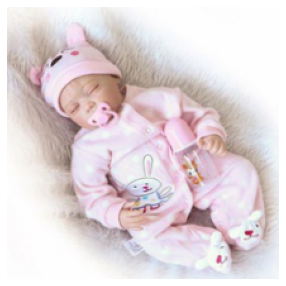

In [ ]:
TensorImage(dls.decode(b)[1][0]).show();

In [ ]:
@typedispatch
@patch
def show_one_batch(b: TfmdDL=None, max_n=2, dls_=dls):
    if b is None: b = dls_.one_batch()
    # print(next(iter(b)))
    items = dls_.decode_batch(b.one_batch())

    x1 = [i[0] for i in items]
    x2 = [Resize(50)(i[1].show()) for i in items];
    y = [i[2] for i in items]
    # display(x1[0])
    # display(pd.DataFrame({'x':x1, 'y':y}, x2))
    for i, (x1_, x2_, y_) in enumerate(zip(x1,x2,y)):
        display(pd.DataFrame({'.':x1_, ' ':y_}, index= [i]),x2_)
        i += 1
        # display(x2_)

In [ ]:
# dls.show_one_batch()  #run to see one_batch

HYBRID MODEL

In [ ]:
def bn_drop_lin_relu(nf, out, p, relu=True):
    layers= [
        nn.BatchNorm1d(nf),
        nn.Dropout(p=p),
        nn.Linear(nf, out)]
    
    if relu: layers.append(nn.ReLU(inplace=True))
    return layers

def load_body(body, pretrained_image_path=None):
    # load resnet body dict from pretrained
    body_model_dict = body.state_dict()
    if pretrained_image_path is not None:
        pretrained_dict = torch.load(pretrained_image_path, map_location=torch.device('cpu'))
        needed_dict = {k:v for k, v in pretrained_dict['model'].items() if k in body_model_dict.keys()}
        body_model_dict.update(needed_dict)
    body.load_state_dict(body_model_dict)

def create_body_feat(m, p, pretrained_image_path, last=512):
    body = create_body(m)
    nf = num_features_model(body)
    layers = list(body.children()) + [AdaptiveConcatPool2d(), Flatten()] + bn_drop_lin_relu(nf*2, last, p)
    body = nn.Sequential(*layers)
    # load_body(body, pretrained_image_path)
    return body, last

def get_text_data(df):
    txt_blk_cls = TextBlock.from_df(text_cols=['Title', 'Description'],
                                vocab=dls.vocab[0],
                                is_lm=False, 
                                seq_len=MAX_SEQ_LEN,                                 
                                tok_func=SpacyTokenizer, 
                                lang='fr', 
                                res_col_name='text')
    db_lm = DataBlock(blocks=txt_blk_cls, 
                    get_x=ColReader('text'), 
                    splitter=RandomSplitter(valid_pct=0.1, seed=42))
    
    dls_lm = db_lm.dataloaders(df, bs=8, seq_len=MAX_SEQ_LEN)
    return dls_lm

def prep_text_model(seq_len, p, encoder_path=None, last=50):
    clas_learn = text_classifier_learner(get_text_data(df_all), arch=AWD_LSTM, loss_func=CrossEntropyLossFlat)
    if encoder_path is not None: clas_learn.load_encoder(encoder_path)
    layers = list(clas_learn.model.children())[:-1]
    return SequentialRNN(*layers, PoolingLinearClassifier([1200, 100, last], ps=[p]*2, bptt=seq_len)), last

In [ ]:
class HybridModel(nn.Module):
    def __init__(self, img_body, text_body, imft, txtft, c):
        super().__init__()
        # image
        self.img_body, self.imft = img_body, imft

        # text
        self.text_body, self.txtft = text_body, txtft

        #merge
        self.merge = nn.Sequential(*bn_drop_lin_relu(self.imft+self.txtft, 128, p))

        #final
        self.final = nn.Sequential(*bn_drop_lin_relu(128, c, 0., False))
        
    def forward(self, x1, x2):
        # text
        x1 = self.text_body(x1)[0] #Sselect only the true output, leave the dropout and raw outputs for use with RNNRegularizer        

        # image
        x2 = self.img_body(x2)

        # concat
        cat = torch.cat([x1, x2], dim=1)

        # merge layer (bn+relu)
        out = self.merge(cat)

        # dense layer (bn+relu) to output
        out = self.final(out)

        return out

In [ ]:
# didn't yield good results

# # grab the encoder mani trained
# mani_path = colab_path/'models/mani_full_baseline.pth'

# # grab the pretrained model tendo trained
# tendo_path = colab_path/'models/img_10000_baseline.pth'

In [ ]:
p = 0.25 #dropout
seq_len = 72

encoder_path = None #mani_path #language model encoder
pretrained_image_path = None #tendo_path #tendo pretrained image model


img_body, imft = create_body_feat(resnet50, p, pretrained_image_path)
text_body, txtft = prep_text_model(encoder_path=encoder_path, seq_len=seq_len, p=p)

In [ ]:
model = HybridModel(img_body, text_body, imft, txtft, dls.c)

## Training

In [ ]:
from sklearn.metrics import f1_score
#Training Evaluation
def macro_f1_score(y_pred, y_test):
    score = f1_score(y_test, y_pred.argmax(-1), average="macro")
    return score

In [ ]:
def hybrid_splitter(m):
    'split the model from the body'
    groups = [nn.Sequential(m.img_body, m.text_body)] + [m.merge, m.final]
    return L(groups).map(params)

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=hybrid_splitter,
                metrics=[accuracy, AccumMetric(macro_f1_score, flatten=False)])

In [ ]:
learn.freeze()

In [ ]:
# learn.summary()

In [ ]:
# learn.validate()

(#3) [2.8494129180908203,0.22750000655651093,0.08286069602062149]

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=2.75422871709452e-06)

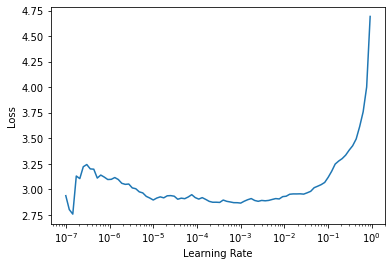

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, 3e-03)

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=9.12010818865383e-07)

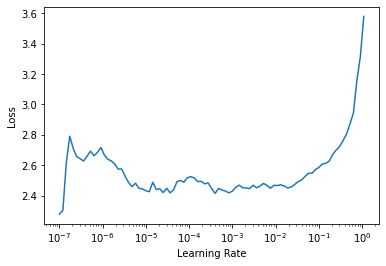

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, slice(1e-05, 1e-03))

KeyboardInterrupt: ignored

In [ ]:
learn.save(colab_path/'models/hybrid_model')

## EValuation

In [ ]:
TEST_FILENAME=colab_path/'SIGIR-2020-EComDC-release/data/x_test_task1_phase1.tsv'
test_df = pd.read_csv(TEST_FILENAME, sep='\t')

In [ ]:
test_df['Description'] = test_df['Description'].fillna(' ')

In [ ]:
test_df.head()

,Integer_id,Title,Description,Image_id,Product_id
0,0,Jeep Police - Gevarm-Gevarm,,1193217616,3136702026
1,1,Court Joyeux Noël En Peluche Taie Sofa Set Pad Décoration 18x18 Pouces Pillow Case 28537,Joyeux Noël en peluche court Taie Sofa Set Pad Décoration 18x18 pouces Spécification: Matériel: style court peluche: Taille de mode (approx.): 45x45cm La taille peut avoir un écart de 0.5-2cm en raison de produit par date. Entretien: Lavable à la main ou lavage à l&#39;eau froide au cycle délicat. Ne pas utiliser l&#39;eau de Javel. Fermeture à glissière cachée. Insérer est vendu séparément Il peut être utilisé pour décorer le salon faire paraître à la maison chaleur plus confortable. Remarque: S&#39;il vous plaît permettre erreur mineure en raison de la mesure manuelle. En raison de la di...,1323615566,4231863665
2,2,Sauna infrarouge Largo - 170 x 105 x 190 - Pin blanc,Dimensions : 150x105x190 cm ou 170x105x190 cm //// Nombre de places : 2 - 3 places assises //// Extérieur : Au choix : érable ou pin blanc ou cèdre rouge //// Intérieur : Au choix : érable ou pin blanc ou cèdre rouge //// Verre : Verre trempé 8-10 mm //// Température ajustable : Oui //// Contrôles et réglages : Panneau de commande tactile GD530 //// Multimédia : Radio station à mémoire avec connexion CD //// Poêle : Conduite chauffante //// Lumières : Lampe à lumière colorée Panneau en bois rétroéclairé.,1158121321,2695198357
3,3,BAGUE POUR LAME SOUS-SOLEUSE G. ET D.,,1096607258,1657064583
4,4,Carnet De Notes Bloc-Notes Cahierindian Squelette Flamen Pr¿º Tre Sacrifice Totem Taustration Sch¿¿Ma Les Carnets De Travail Classique Sur Support Papier Cadeau Tissu,Taille: En format A5 (144 cm x 21 cm) Caract¿¿ristique: -Excellente durabilit¿¿ avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit¿¿: ¿¿crire facilement sur et assez ¿¿paisse.,1303625028,4159071068


add image path to the test_df

In [ ]:
# all images in test set
test_img_path = colab_path/'SIGIR-2020-EComDC-release/image/image_test'

In [ ]:
test_files = get_image_files(test_img_path); len(test_files)

1381

In [ ]:
test_df.shape

(937, 5)

In [ ]:
test_prdid2path_dict = dict()
pat = r'([0-9]+).jpg$'
for img_path in test_files:
    idx = re.search(pat, str(img_path)).group(0)
    # if int(idx[:-4]) == id_:
    test_prdid2path_dict[int(idx[:-4])] = img_path

In [ ]:
def add_img_path(id_):
    return test_prdid2path_dict[id_]

In [ ]:
test_df['image_path'] = test_df.Product_id.apply(add_img_path)

In [ ]:
test_items = tokenize_df(df=test_df[:6], text_cols=['Title', 'Description'], mark_fields=True, tok_func=SpacyTokenizer, lang='fr', res_col_name='text')

In [ ]:
test_dl = learn.dls.test_dl(test_items = test_items[0])

In [ ]:
# test_dl.show_batch()   #yet to be implemented. Just use typedispatch

In [ ]:
# test_dl.one_batch()

In [ ]:
preds_raw, _, preds = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
learn.dls.categorize.vocab[preds]

(#6) [2705,2705,2705,2705,2705,2705]

In [ ]:
test_df.loc['Prdtypecode', :] = learn.dls.categorize.vocab[preds]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_df.head(2)

In [ ]:
test_df[['Integer_id', 'Image_id', 'Product_id', 'Prdtypecode']].to_csv(colab_path/'submission_baseline_10000_score_38.4.tsv', index=False, sep='\t')